# How to Calibrate TopoFlow with Gauge Data

#### Table of Contents

1.  <a href="#intro_G">Introduction</a> <br>
2.  <a href="#install_G">How to Install the TopoFlow Python Package</a> <br>
3.  <a href="#guess_G">Calibration vs. Best-Guess Parameters</a> <br>
4.  <a href="#cost_fcn_G">Defining the Cost Function</a> <br>
5.  <a href="#cal_module_G">The TopoFlow Calibrate Module</a> <br>
6.  <a href="#gauge_data_G">River Discharge Data for Treynor Creek, Iowa</a> <br>
7.  <a href="#calibrate_G">TopoFlow Calibration for Treynor Creek </a> <br>
8.  <a href="#conclusions_G">Conclusions </a> <br> 
9.  <a href="#notebooks_G">Other Jupyter Notebooks for TopoFlow 3.6 </a> <br>
10. <a href="#refs_G">Key References for TopoFlow</a> <br>
11. <a href="#setup_G">Appendix 1: Installing TopoFlow in a conda Environment</a>

<!-- Hyperlink IDs must be unique to work in Jupyter Lab when
there are multiple notebooks open. Hence the trailing letter. -->

## Introduction  <a id="intro_G"></a>

This notebook shows a simple model calibration exercise for the TopoFlow 3.6 hydrologic model that uses river discharge measurements from a gauging station.  Model calibration is computationally expensive and is best performed on supercomputers with specialized toolkits such as [<b>DAKOTA</b>](https://dakota.sandia.gov/) from DOE's Sandia Labs.  It basically involves performing a very large number of model runs with different combinations of the adjustable parameters to find the set of parameters that results in the closest match between observations of some variable and model predictions for the same variable.  The goal of this notebook is to show how calibration works using a grealy <b>simplified example</b> where only one model parameter is considered to be adjustable.  A future notebook will illustrate a more complex and realistic example of model calibration for TopoFlow.


## How to Install the TopoFlow Python Package  <a id="install_G"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.

Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup_G"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.

## Calibration vs. Best-Guess Parameters  <a id="guess_G"></a>

Model <b>calibration</b> is one commonly-used method for
[<b>parameter estimation</b>](https://en.wikipedia.org/wiki/Estimation_theory)
(PE).  This method requires the use of a
[<b>cost function</b>](https://en.wikipedia.org/wiki/Loss_function)
that compares the <b>observed</b> or measured values of some variable to the values that are <b>predicted</b> by a model for that same variable.  It is important to understand that this method of parameter estimation <b>requires</b> observational data;  it cannot be used when observational data is unavailable.  For most of the river basins in the world, and especially on the African continent, observational data is only available for a relatively small number of river basins;  typically just the largest basins.

For hydrologic models, it is common to use a time series of
[<b>river discharge</b>](https://en.wikipedia.org/wiki/Discharge_(hydrology))
(which has units of volume per time), as the variable that is both observed and predicted, at some river basin outlet where there is a gauging station.  The modeler decides which model parameters will be held fixed and which will be allowed to be set by this method, and the model is then run many, many times, each time using a different set of possible parameter values (over allowed ranges) and each time computing the value of the cost function.  This is an
[<b>optimization problem</b>](https://en.wikipedia.org/wiki/Optimization_problem),
where one seeks the global minimum of the cost function over the model's
[<b>parameter space</b>](https://en.wikipedia.org/wiki/Parameter_space).
The cost function is often simply an
[<b>L2 norm</b>](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm)
(i.e. least squares difference) that measures how close the model predictions are to the observations.  When finished, the model's adjustable parameters are set to those of the model run that minimized the cost function.  Unfortunately, it can happen that many different sets of parameters will minimize the cost function equally well, and this problem is called
[<b>equifinality</b>](https://en.wikipedia.org/wiki/Equifinality).

Since model calibration utilizes observational data, measurement errors of any kind can be a problem.  Also, a model must be recalibrated when it is applied to a different location (e.g. another river basin).  And due to the likely
[<b>nonstationarity</b>](https://en.wikipedia.org/wiki/Stationary_process)
of weather variables, it may also need to be recalibrated when it is applied to different time period or to any circumstances that were not reflected in the observational data (such as a large flood event).

In the common case where observational data is not available, a domain expert will gather as much information about the region (and scenario) of interest as possible, from any available source (e.g. papers, books, websites, global databases, personal communication, etc.), and combine this with his or her understanding of the underlying physics (expert knowledge) and a few assumptions to make <b>best guesses</b> for the values of adjustable parameters.  Neither calibration nor this method is foolproof, so model predictions always have uncertainty.  Note that even a perfect model (if that were possible) will give incorrect and even nonsensical results if its parameters are set incorrectly.

A closely related topic is
[<b>model sensitivity analysis</b>](https://en.wikipedia.org/wiki/Sensitivity_analysis).
As with model calibration, a model sensitivity study requires a model to be run many, many times with different parameter settings.  However, the goal in this case is to determine the degree to which the model predictions (i.e. the numerical values of the output variables) are <b>sensitive</b> to changes in any given parameter.  Physically-based models, where each parameter represents some important aspect of the physics, can be sensitive to many of their parameters.  In some cases a model may even become chaotic or exhibit a discontinuous jump in its predicted values even after a parameter is changed by only a very tiny amount.


## Defining the Cost Function  <a id="cost_fcn_G"></a>

Model calibration is an <b>optimization problem</b>, and this type of problem starts with the definition of a <b>cost function</b>, which may also be called an <b>objective function</b> or a 
[<b>loss function</b>](https://en.wikipedia.org/wiki/Loss_function).

The cost function must be a
[<b>metric</b>](https://en.wikipedia.org/wiki/Metric_(mathematics))
that measures model's performance, defined as an abstract "distance" between the observed and model-predicted values of some output variable. There are many different metrics that can be used, such as those based on the one-parameter family of L<sup>p</sup> norms, given by:

$$ \large{
d \left( \boldsymbol{Y}_{obs}, \boldsymbol{Y}_{sim} \right) =
\left( \sum_{k=1}^n \left| y_k^{(obs)} - y_k^{(sim)} \right|^{\,p} \right)^{1/p}
} $$

where
$Y_{obs}$ is a vector of observed values with components $y_k^{\, (obs)}$,
$Y_{sim}$ is a vector of simulated values with components $y_k^{\, (sim)}$,
and $p > 0$ is a scalar. The case where $p = 2$, the or the $L^2$ norm, is the basis of the popular
[<b>least squares</b>](https://en.wikipedia.org/wiki/Least_squares) metric.  While this metric gives disproportionate weight to outliers, it ensures that the derivative of the cost function is continuous where the error is zero.

When calibrating a hydrologic model, it is common to use an observed and simulated time series of <b>river discharge</b> values (at the outlet of a river basin) for the vectors $Y_{obs}$ and $Y_{sim}$.  In this case, $k$ may be seen as a time index.  Notice that the cost, $d$, can only be zero if all of the simulated and observed values are the same.

While not indicated explicitly in the notation above, it is understood that the vector of simulated values, $Y_{sim}$, is a function of the values of all of the model's adjustable parameters, sometimes called <b>control parameters</b> or <b>design parameters</b>.

## The TopoFlow Calibrate Module  <a id="cal_module_G"></a>

We now import TopoFlow's <b>calibrate</b> module from <b>topoflow/utils</b> and explain some of its features.
This module reads required information about the observed and predicted time series from a configuration (CFG) file called <b>calibrate.cfg</b>.  Note that simulated values from TopoFlow will be stored with a fixed time interval between values (i.e. regular spacing in time), but the observed values are often stored with an irregular time interval.  Because of this observed values often need to be <b>regularized</b>, or interpolated to the same times associated with the simulated values before computing the cost function.  Also, observed times (and sometimes dates), may use different formats such as "hhmm", "datetime" (e.g. 2015-10-01 12:34:56), or "timesince".  The <b>calibrate</b> module automatically deals with all of these issues.

The <b>calibrate</b> module contains a class called <b>calibrator</b>.  We first create an instance of this class, call some of its <b>method functions</b>, and show how to print out some of the data it contains.

### Run TopoFlow Once with Default Parameters

Before starting the calibration exercise, which requires multiple model runs, we will run TopoFlow once with default parameters.  We can then use the resulting output files to illustrate some of the features of the <b>calibrate</b> module.  Recall from the Getting Started notebook that the default output directory is called: <b>TF_Output/Treynor</b>, in your home directory.  TopoFlow never overwrites existing files, but instead appends a number just before the filename extension.   Note that we set the SILENT keyword to False to suppress all output, as done by the <b>calibrate</b> module.

In [1]:
from topoflow import main
from topoflow.framework import emeli
examples_dir  = emeli.paths['examples']
cfg_directory = examples_dir  + 'Treynor_Iowa_30m/'
time_interp_method = 'None'
# time_interp_method = 'Linear'

cfg_prefix = 'June_20_67'
cfg_dir = cfg_directory + '__No_Infil_June_20_67_Rain/'
print('Running...')
main.run_model(cfg_prefix=cfg_prefix, cfg_directory=cfg_dir,
               SILENT=True,  ### (always used for calibration)
               time_interp_method=time_interp_method)
print('Finished.')

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Running...
Finished.


### Import and Instantiate the Module

Create an instance of the "calibrator" class.

In [2]:
from topoflow.utils import calibrate
cal_cfg_file  = cfg_dir + 'calibrate.cfg'
cal = calibrate.calibrator(cfg_file=cal_cfg_file)

### Call Some of Its Method Functions

In [3]:
cal.print_cfg_info()

In print_cfg_info():
site_prefix  = Treynor
cfg_prefix   = June_20_67
home_dir     = /Users/peckhams/
basin_dir    = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/
topo_dir     = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__topo/
cfg_dir      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__No_Infil_June_20_67_Rain/
output_dir   = /Users/peckhams/TF_Output/Treynor/
------------------------------------------------------
obs_dir            = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__observations/
obs_data_file      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__observations/June_20_1967_Observed_Discharge.txt
obs_data_delim     = None
obs_time_format    = hhmm
obs_time_interval  = irregular
obs_time_units     = minutes
obs_start_datetime = 1967-06-20 20:57:00
obs_header_lines   = 6
obs_time_column    = 0
obs_value_column   = 5
obs_interp_method  =

In [4]:
#-------------------------------------------
# Read simulated values from the last run,
# and then read observed values
#-------------------------------------------
cal.get_simulated_values( SILENT=False )
cal.get_observed_values( SILENT=False )

In get_simulated_values():
Sim time format    = timesince
Sim time interval  = 1.0
Min(sim_times)     = 0.0
Max(sim_times)     = 35.0
Min(sim_values)    = 0.0
Max(sim_values)    = 102.93545

Reading time series data...
Interpolating obs. time series data...

In get_observed_values():
Obs time format    = hhmm
Obs time interval  = irregular
obs_values.size    = 36
Min(obs_values)    = 0.001488146954216063
Max(obs_values)    = 11.735101699829102

obs_values_orig.size = 84
Min(obs_values_orig) = 0.001488147
Max(obs_values_orig) = 12.415398


### Print Values of Some of its Variables

In [5]:
print(cal.sim_start_datetime)
print(cal.sim_time_units)
print(cal.sim_time_format)
print(cal.sim_times[0:5])
print(cal.sim_times.max())
print(cal.sim_times.size)
print()
print(cal.obs_start_datetime)
print(cal.obs_time_units)
print(cal.obs_time_format)
print(cal.obs_times[0:10])
print(cal.obs_times[-10:])
print(cal.obs_times.size)

1967-06-20T20:57:00
minutes
timesince
[0. 1. 2. 3. 4.]
35.0
36

1967-06-20 20:57:00
minutes
hhmm
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
36


### Compute the Cost Function for One Model Run

In [6]:
Y_obs = cal.obs_values
Y_sim = cal.sim_values
n_obs = Y_obs.size   #  ndarrays
n_sim = Y_sim.size
if (n_obs < n_sim):
    Y_sim = Y_sim[0:n_obs]
else:
    Y_obs = Y_obs[0:n_sim]
cost = calibrate.Lp_norm(Y_obs, Y_sim) 
print( cost )

95.3174793862771


### Plot the Observed and Simulated Values with Options

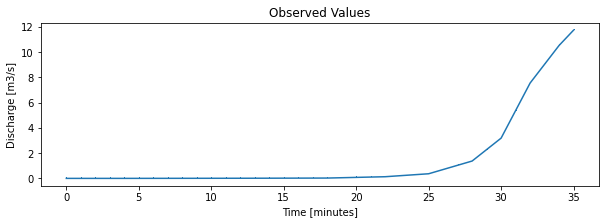

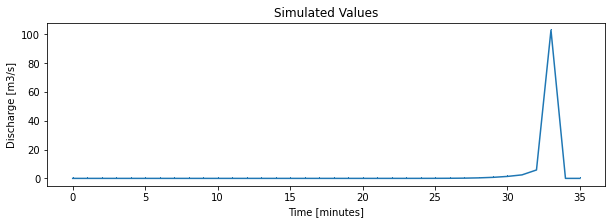

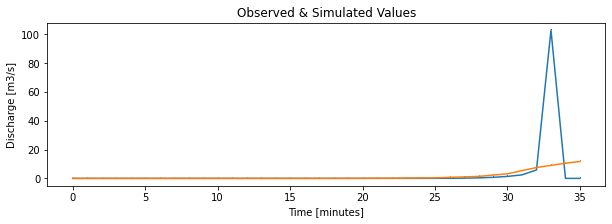

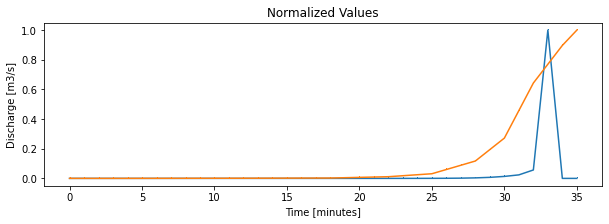

In [7]:
cal.plot_time_series(obs_only=True, marker=',', title='Observed Values')
cal.plot_time_series(sim_only=True, marker=',', title='Simulated Values')
cal.plot_time_series(marker=',', title='Observed & Simulated Values')
cal.plot_time_series(normalize=True, marker=',', title='Normalized Values')

## River Discharge Data for Treynor Creek, in Iowa  <a id="gauge_data_G"></a>

For this simplified calibration exercise, we will use observed river discharge measurements at the mouth of a small, agricultural watershed approximately 6 miles southwest of the town of Treynor, Iowa.  This is one of 5 small USDA research watersheds near Treynor that the USDA refers to as Treynor Watersheds 1 through 5.  For simplicity, we will refer to Watershed 1 as <b>Treynor Creek</b>.  Treynor Creek is a tributary of Silver Creek, in Pottawattamie County (southwest Iowa), which is a tributary of the West Nishnabotna River, in the Missouri River basin.  This is not far from the city of Council Bluffs.

Extreme rainfall events on June 7, 1967 and June 20, 1967 resulted in 100-year flood events in the vicinity of Treynor Creek (Spomer et al. 1971).  Measured rainfall rates and river discharges for these events are included with sample data in the TopoFlow 3.6 package, in <b>topoflow/examples/Treynor_Iowa_30m/\_\_observations</b>.
Source data for the June 20, 1967 event was obtained from Burford and Clark (1971, p. 601-618).
Source data for the June 7, 1967 event was obtained from Burford and Clark (1976, p. 508-522).

### Treynor Creek References

Burford, J.B. and J.M. Clark (1971)
Hydrologic Data for Experimental Agricultural Watersheds in the United States 1967,
Miscellaneous Publication No. 1262, Agricultural Research Service, USDA, Washington, DC.
(The Treynor watershed data is on pages 601-618.)

Burford, J.B. and J.M. Clark (1976)
Hydrologic Data for Experimental Agricultural Watersheds in the United States 1968,
Miscellaneous Publication No. 1330, Agricultural Research Service, USDA, Washington, DC.
(The Treynor watershed data is on pages 508-522.)

Kinner, D.A. and R.F. Stallard (2001)
Calculating hillslope contributions to river basin sediment yield using observations in small watersheds and an index-based model,
American Geophysical Union, Fall Meeting 2001, abstract id. NG51A-0445.

Saxton, K.E., R.G. Spomer and L.A. Kramer (1971)
Hydrology and erosion of loessial watersheds,
J. Hydraulic Division, Proc. ASCE, 23, HY11, 1835-1851.

Spomer, R.G., H.G. Heinemann and R.F. Piest (1971)
Consequences of historic rainfall on western Iowa farmland,
Water Resources Research, 7(3), 524-535.

Vendrusculo, L.G. and A.L. Kaleita (2013)
Terrain analysis and data mining techniques applied to location of a classic gully in a watershed, Proceedings of 2013 ASABE Annual International Meeting, Kansas City, MO, July 21-24, 2013.


## TopoFlow Calibration for Treynor Creek  <a id="calibrate_G"></a>

We now show how to use the TopoFlow <b>calibrate</b> module that was introduced in a previous section to find model parameters that yield the best agreement between observations and model predictions.
This is just a simple calibration where we only allow one parameter to vary, for purposes of demonstration.  The procedure is to perform many model runs where we vary that parameter over its allowed range (i.e. we sample the parameter space) and for each run we compute a cost function that compares predictions to observations.  Finally, we save the value of the parameter that minimizes the cost function.

<b>Note:</b> For a full-fledged calibration exercise, where more parameters would be allowed to vary, the best approach is to use a sophisticated toolkit such as [<b>DAKOTA</b>](https://dakota.sandia.gov/), developed over decades by DOE's Sandia National Lab.
DAKOTA can more rapidly perform a large ensemble of model runs by automatically taking advantage of parallel processing on a supercomputer or cluster.  Details for how to calibrate TopoFlow with DAKOTA will be provided in a future notebook.  In addition to its computational speed, DAKOTA offers an extensive collection of tools and algorithms that go far beyond optimization problems (like model calibration), to encompass all types of <b>uncertainty quantification</b> and <b>sensitivity analysis</b>.


To perform the calibration exercise, we use the <b>calibrate()</b> function of the <b>calibrator</b> object.
This function has a <i>cal_var</i> keyword that determines which <b>calibration variable</b> (or model parameter)
will be varied.  The <b>var_range</b> keyword sets the minimum and maximum value that will be used for this parameter,
while the <b>n_values</b> keyword determines how many equally-spaced values to use to span that range.
(<b>Note</b>: If n_values=n, there will be (n-1) intervals. )

The four calibration variables shown here are used as inputs to a function in TopoFlow's <b>parameterize</b> module that generates an input grid of channel widths or Manning's n roughness values.  These grids have the same dimensions as the DEM, and are estimates computed as power-law functions of the <b>total contributing area</b> (TCA) grid.

For each parameter value, a new input grid is created and a new model run is performed.
After each model run, the cost function is evaluated.

Various 1D arrays are saved in the state of the calibrator object, namely
<blockquote> <ul>
<li> cal.obs_times   &nbsp; (in minutes)
<li> cal.obs_values  &nbsp; (observed values)
<li> cal.sim_times   &nbsp; (in minutes)
<li> cal.sim_values  &nbsp; (simulated values)
<li> cal.params      &nbsp; (the set of parameter values used)
<li> cal.costs       &nbsp; (the cost associated with each parameter value used)
<li> cal.best_param  &nbsp; (the parameter value with the lowest cost)
</ul> </blockquote>
Setting the <b>PLOT</b> keyword to True generates a plot after each model run to compare the observed discharge values for the June 20, 1967 storm to the values that are predicted for the given parameter settings.  The orange curve shows the observed values and the blue curve has the predicted values for a given model run.  These plots are created using TopoFlow's <b>visualize</b> module, in topoflow/utils/visualize.pro. <br> <br>

Keep in mind that we could get a better fit and lower cost by allowing multiple parameters to vary over their allowed ranges.
A future version of this notebook will include that exercise.

### Calibration with Minimum of Manning's n

Working...
   param = 0.01
   cost  = 166.70726572287208
   run_time = 0.04354308446248372 [minutes]


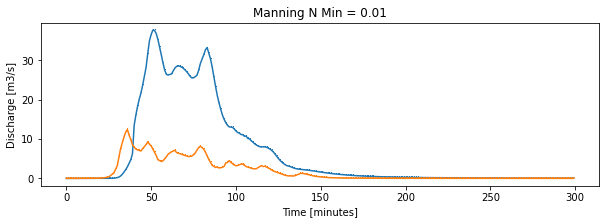

   param = 0.012258064
   cost  = 55.52876782952674
   run_time = 0.04156155188878377 [minutes]


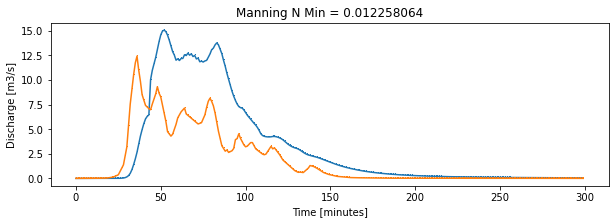

   param = 0.014516128
   cost  = 45.16314115181204
   run_time = 0.0395760973294576 [minutes]


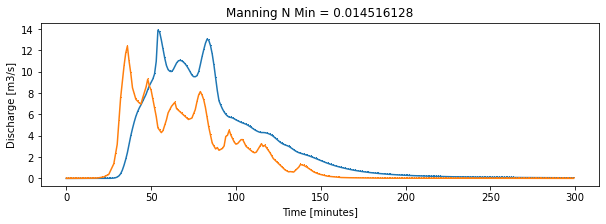

   param = 0.016774192
   cost  = 34.26757362996564
   run_time = 0.0391692320505778 [minutes]


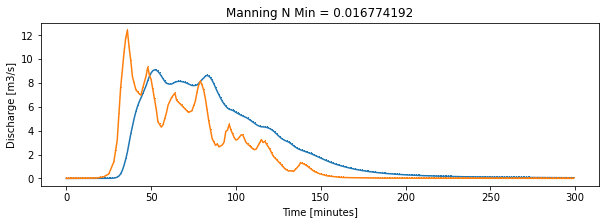

   param = 0.019032259
   cost  = 34.783613410290165
   run_time = 0.040083102385203045 [minutes]


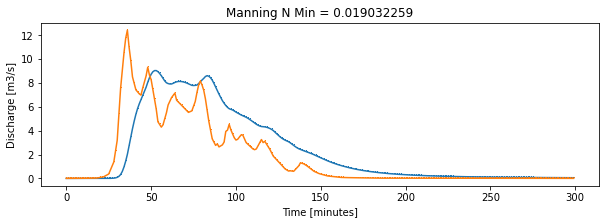

   param = 0.02129032
   cost  = 35.25539509301272
   run_time = 0.03969026406606038 [minutes]


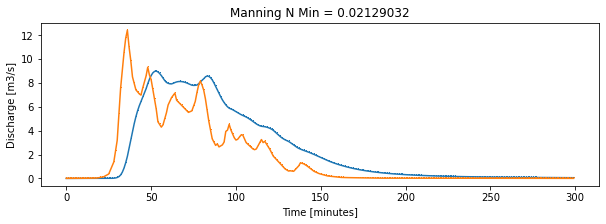

   param = 0.023548387
   cost  = 35.69028629050387
   run_time = 0.0421843687693278 [minutes]


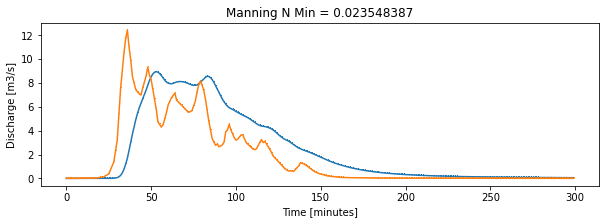

   param = 0.025806451
   cost  = 36.09365796113114
   run_time = 0.04218631585439046 [minutes]


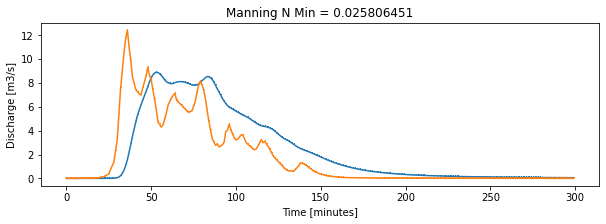

   param = 0.028064515
   cost  = 36.46976681773817
   run_time = 0.04361291329065959 [minutes]


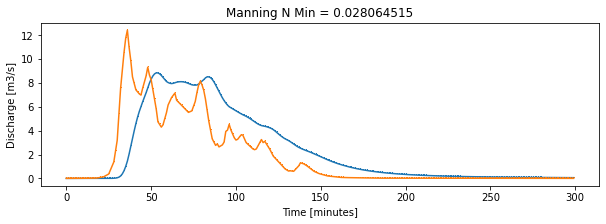

   param = 0.03032258
   cost  = 36.82207023119946
   run_time = 0.04396511713663737 [minutes]


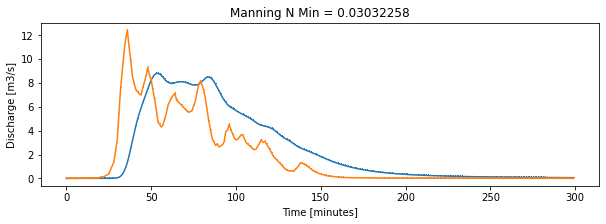

   param = 0.032580644
   cost  = 37.15343331279866
   run_time = 0.03978445132573446 [minutes]


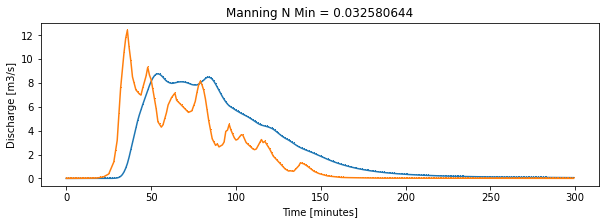

   param = 0.034838706
   cost  = 37.466259038207944
   run_time = 0.039387599627176924 [minutes]


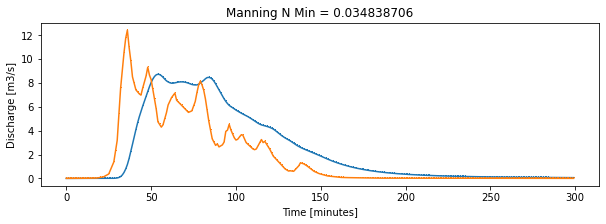

   param = 0.037096776
   cost  = 37.76258202986232
   run_time = 0.04257069826126099 [minutes]


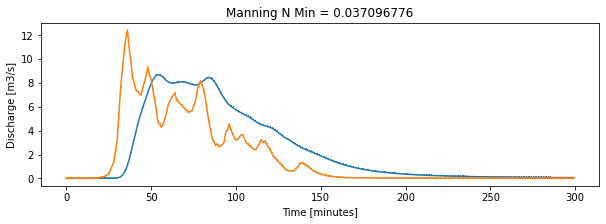

   param = 0.03935484
   cost  = 38.044140281915816
   run_time = 0.04212953249613444 [minutes]


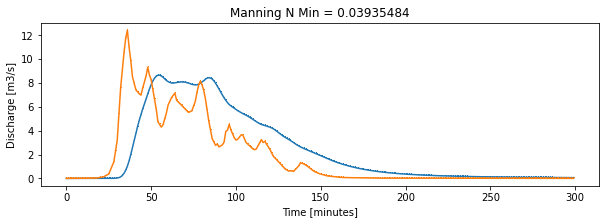

   param = 0.0416129
   cost  = 38.312428373393765
   run_time = 0.040143362681070965 [minutes]


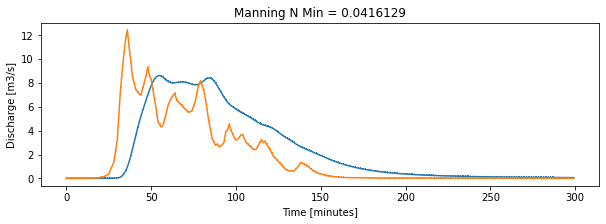

   param = 0.043870963
   cost  = 38.56874363288274
   run_time = 0.04071828126907349 [minutes]


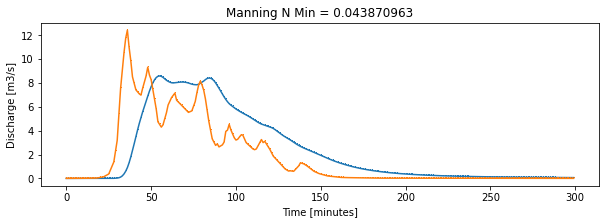

   param = 0.046129033
   cost  = 38.81420832601222
   run_time = 0.042423764864603676 [minutes]


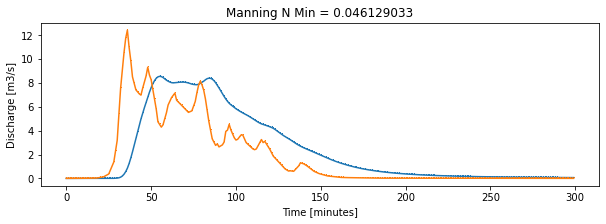

   param = 0.048387095
   cost  = 39.04980604355738
   run_time = 0.040800297260284425 [minutes]


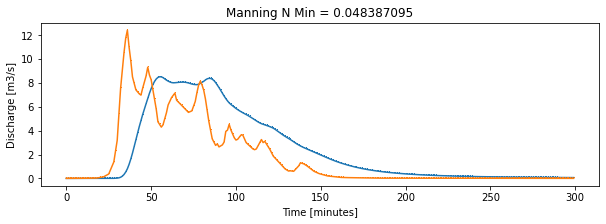

   param = 0.050645158
   cost  = 39.27639882583295
   run_time = 0.04300348361333211 [minutes]


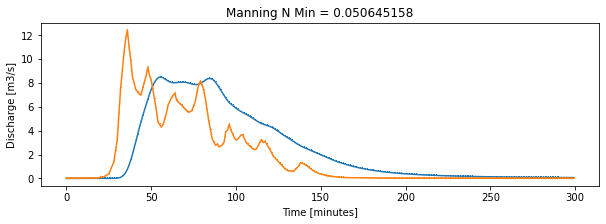

   param = 0.052903228
   cost  = 39.49474567570748
   run_time = 0.04203464984893799 [minutes]


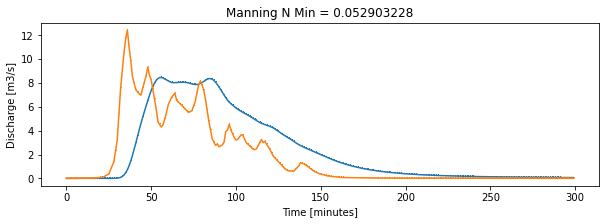

   param = 0.05516129
   cost  = 39.705515917260804
   run_time = 0.04270219802856445 [minutes]


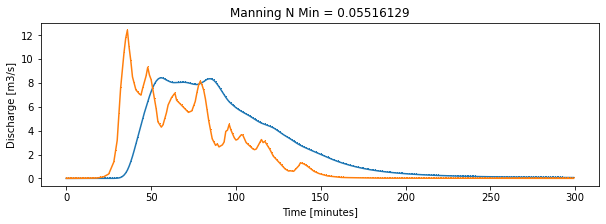

   param = 0.057419352
   cost  = 39.9093041833398
   run_time = 0.04107273022333781 [minutes]


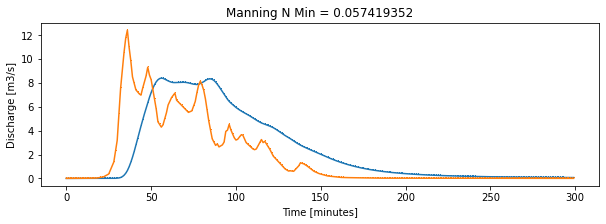

   param = 0.059677415
   cost  = 40.10663691288495
   run_time = 0.041408570607503255 [minutes]


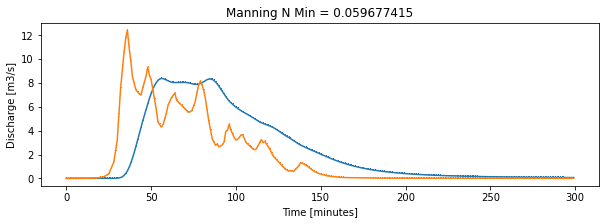

   param = 0.061935484
   cost  = 40.29798352079707
   run_time = 0.040091268221537274 [minutes]


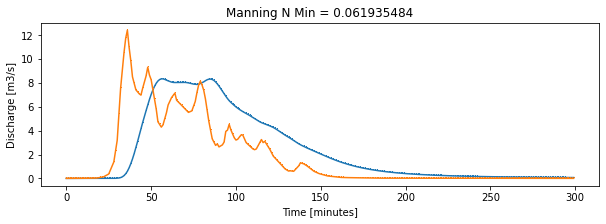

   param = 0.06419355
   cost  = 40.48376394978929
   run_time = 0.04144290288289388 [minutes]


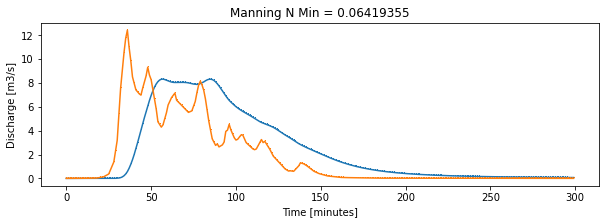

   param = 0.06645162
   cost  = 40.66435156886128
   run_time = 0.040586864948272704 [minutes]


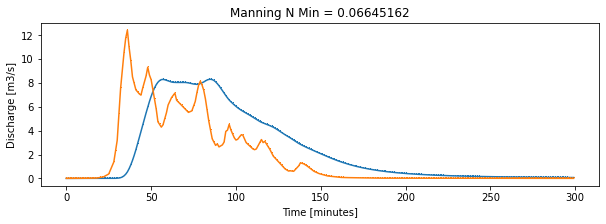

   param = 0.06870968
   cost  = 40.84008303602908
   run_time = 0.04056714375813802 [minutes]


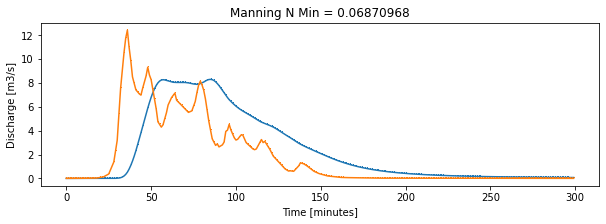

   param = 0.07096774
   cost  = 41.01126008248691
   run_time = 0.040990698337554934 [minutes]


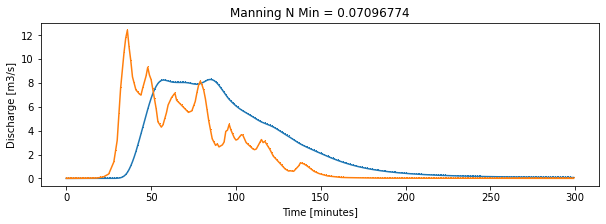

   param = 0.0732258
   cost  = 41.17815217361371
   run_time = 0.042441487312316895 [minutes]


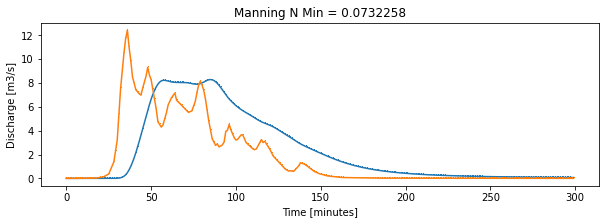

   param = 0.075483866
   cost  = 41.341006825407334
   run_time = 0.04199151992797852 [minutes]


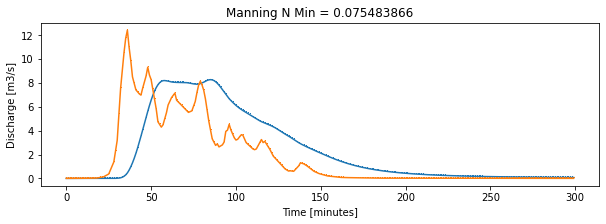

   param = 0.07774193
   cost  = 41.5000436769835
   run_time = 0.03943321704864502 [minutes]


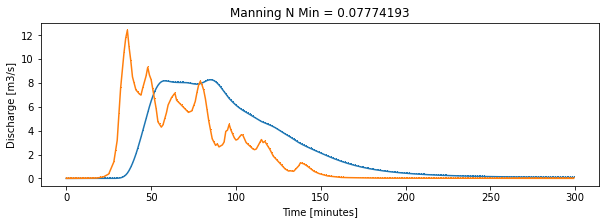

   param = 0.08
   cost  = 41.65546311348907
   run_time = 0.040052485466003415 [minutes]


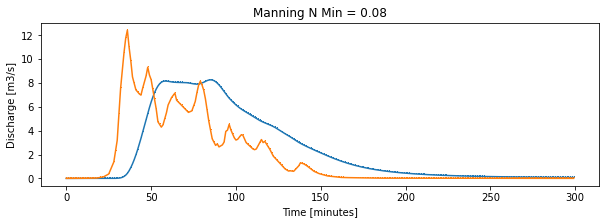

In [11]:
cal.calibrate( cal_var='manning_n_min', var_range=[0.01, 0.08], n_values=32,
               channel_width_max=2.0, channel_width_power=0.5, manning_n_max=0.3,
               PLOT=True, SILENT=True )

### Print out the parameter values and their associated costs

For the case where the adjustable parameter is <b>manning_n_min</b>, a value of about <b>0.012</b> minimizes the cost function.   A lower value of 0.01 makes the first 2 peaks too high, while values larger than 0.012 causes all peaks to be shifted to the right (i.e. lag in time) and to be increasingly less well resolved. 

Note that the
[<b>Manning's n roughness parameter</b>](https://en.wikipedia.org/wiki/Manning_formula)
decreases downstream (as total contributing area, or TCA increases), and a typical value for a river channel is around 0.02 or 0.03.  Manning's formula is often used for overland flow as well, where the roughness and momentum loss is much greater.  Some typical overland flow values are:<br>
(0.04: grass meadow, 0.08: harvested corn, 0.16: corn field, 0.32: forest, 0.64: dense forest).
See: http://cidbimena.desastres.hn/pdf/eng/doc5646/doc5646-8b.pdf (Table 8.5).

<!--
<table>
<tr> <td>0.04</td> <td>grass meadow</td> </tr>
<tr> <td>0.08</td> <td>harvested corn</td> </tr>
<tr> <td>0.16</td> <td>corn field</td> </tr>
<tr> <td>0.32</td> <td>forest</td> </tr>
<tr> <td>0.64</td> <td>dense forest</td> </tr>
</table>
-->

In [11]:
print('best param =', cal.best_param)
print('params =', cal.params)
print('costs  =', cal.costs)


best param = 0.012
params = [0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024 0.026 0.028 0.03  0.032
 0.034 0.036 0.038 0.04 ]
costs  = [54.07837547 28.20168699 29.08469991 29.78671728 30.41833791 30.98926581
 31.50695383 31.97774035 32.40714713 32.80001707 33.16057511 33.49250419
 33.79900621 34.08287789 34.34656599 34.59221652]


### Calibration with Maximum Value of Manning's n

Working...
   param = 0.02
   cost  = 28.676276913981766
   run_time = 0.040846363703409834 [minutes]


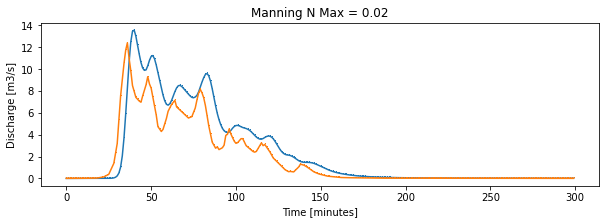

   param = 0.032
   cost  = 30.242591731741317
   run_time = 0.04070091644922892 [minutes]


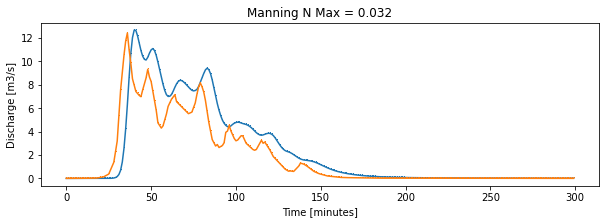

   param = 0.044
   cost  = 31.23049882861722
   run_time = 0.04092303117116292 [minutes]


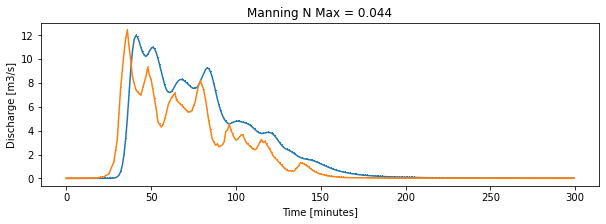

   param = 0.056
   cost  = 31.93513830154577
   run_time = 0.043492968877156576 [minutes]


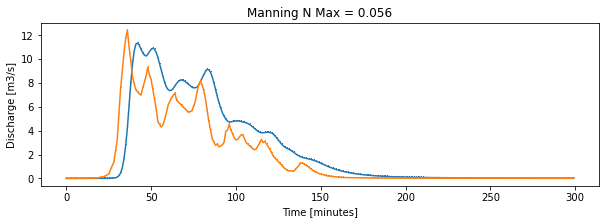

   param = 0.068
   cost  = 32.48033528745348
   run_time = 0.042756434281667074 [minutes]


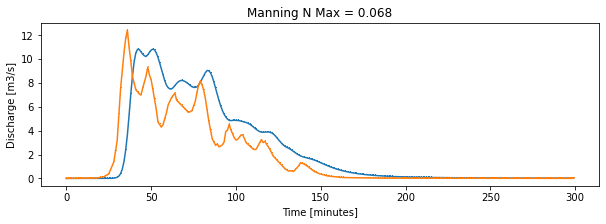

   param = 0.08
   cost  = 32.92660258234964
   run_time = 0.041686832904815674 [minutes]


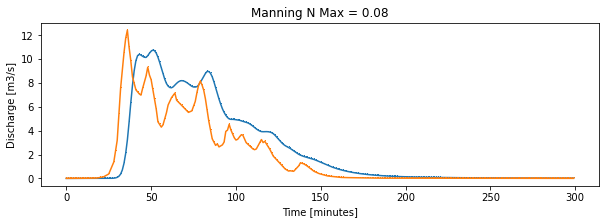

   param = 0.09200001
   cost  = 33.306766604547484
   run_time = 0.040120267868041994 [minutes]


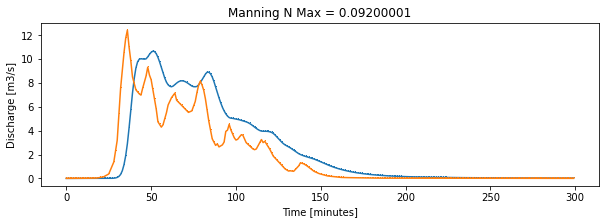

   param = 0.104
   cost  = 33.640090240178154
   run_time = 0.04033815066019694 [minutes]


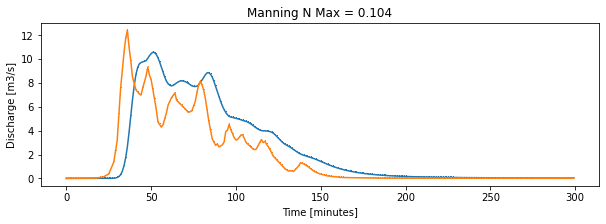

   param = 0.11600001
   cost  = 33.93860713930085
   run_time = 0.0398400624593099 [minutes]


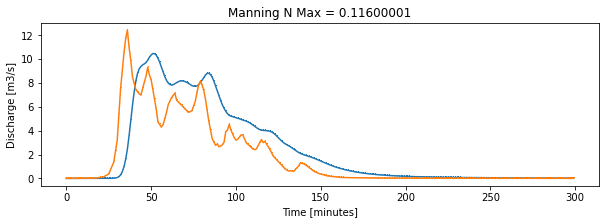

   param = 0.128
   cost  = 34.210229329661445
   run_time = 0.04137124617894491 [minutes]


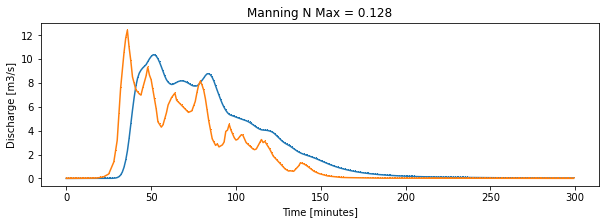

   param = 0.14
   cost  = 34.460394386849394
   run_time = 0.04389883279800415 [minutes]


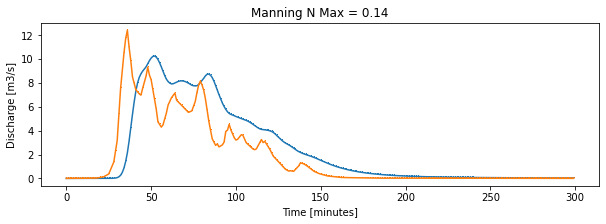

   param = 0.15200001
   cost  = 34.69297759130648
   run_time = 0.04105994701385498 [minutes]


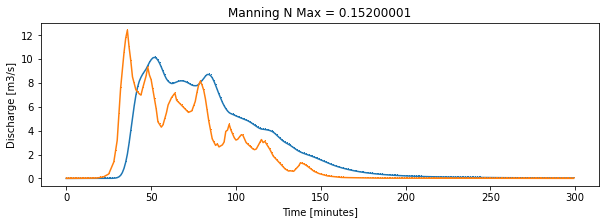

   param = 0.164
   cost  = 34.9108357186292
   run_time = 0.04204601446787516 [minutes]


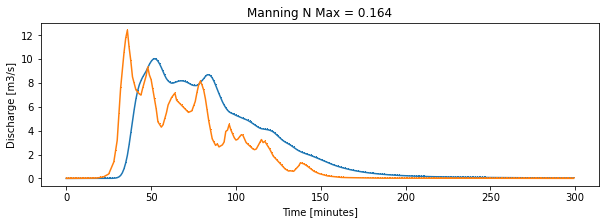

   param = 0.176
   cost  = 35.1161322669362
   run_time = 0.04077305396397909 [minutes]


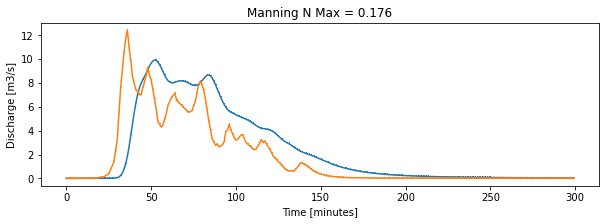

   param = 0.18800001
   cost  = 35.31054697570157
   run_time = 0.04018909931182861 [minutes]


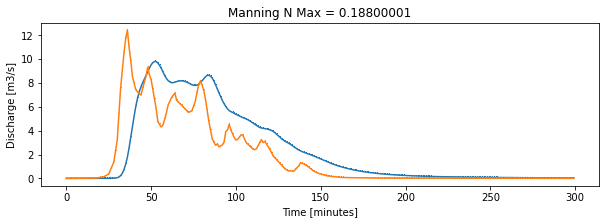

   param = 0.2
   cost  = 35.49541396136393
   run_time = 0.040496333440144854 [minutes]


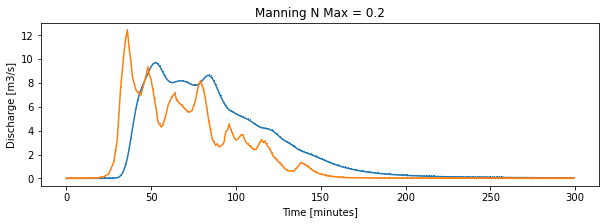

In [14]:
cal.calibrate( cal_var='manning_n_max', var_range=[0.02, 0.2], n_values=16,
               PLOT=True, SILENT=True )

### Calibration with Channel Width Power

Working...
   param = 0.1
   cost  = 49.465622542746814
   run_time = 0.039557544390360515 [minutes]


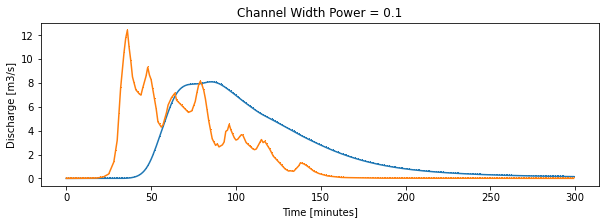

   param = 0.11612903
   cost  = 49.183323904716744
   run_time = 0.03923495213190715 [minutes]


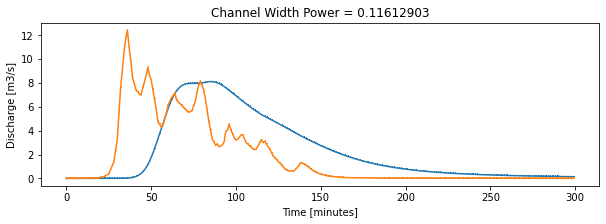

   param = 0.13225806
   cost  = 48.90731216711924
   run_time = 0.04225211540857951 [minutes]


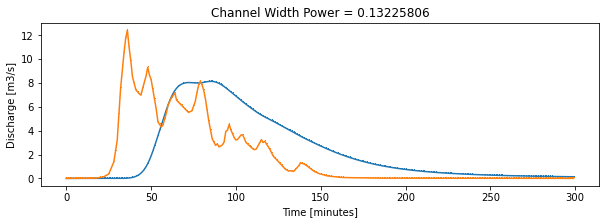

   param = 0.1483871
   cost  = 48.63775558669391
   run_time = 0.04065926869710287 [minutes]


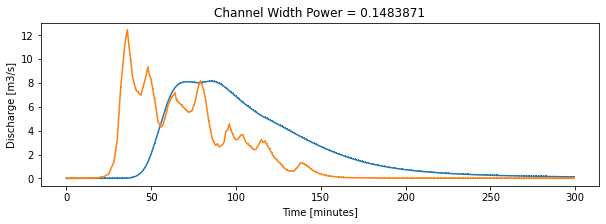

   param = 0.16451612
   cost  = 48.374722955526266
   run_time = 0.038709747791290286 [minutes]


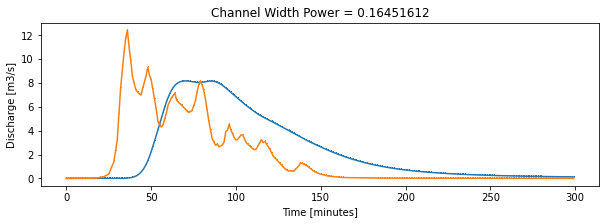

   param = 0.18064517
   cost  = 48.118174058529384
   run_time = 0.038782286643981936 [minutes]


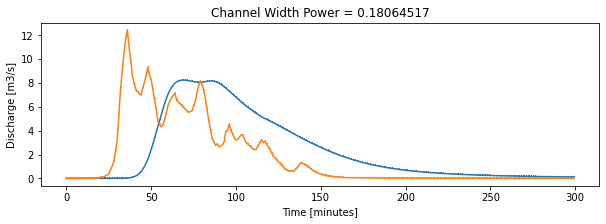

   param = 0.19677418
   cost  = 47.86795588734087
   run_time = 0.041661834716796874 [minutes]


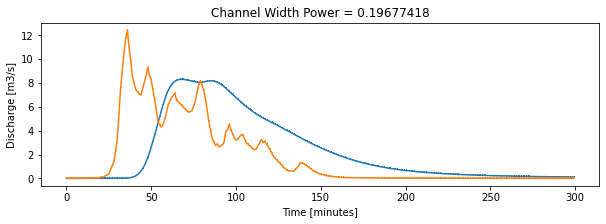

   param = 0.21290323
   cost  = 47.623806309549586
   run_time = 0.04291535218556722 [minutes]


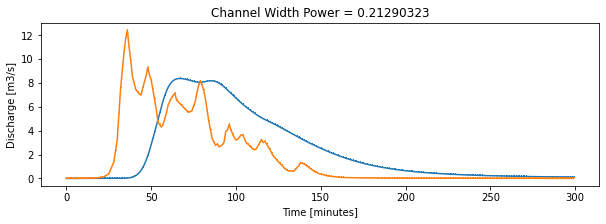

   param = 0.22903225
   cost  = 47.385356278205954
   run_time = 0.042828702926635744 [minutes]


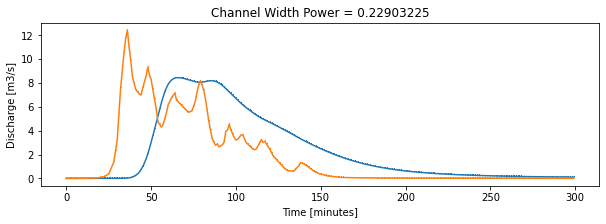

   param = 0.2451613
   cost  = 47.15213779782471
   run_time = 0.03961476484934489 [minutes]


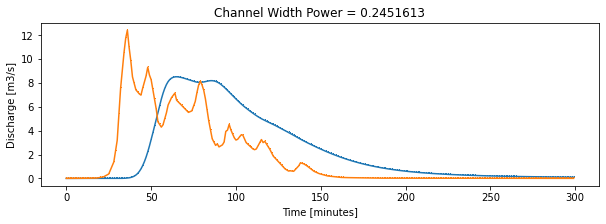

   param = 0.2612903
   cost  = 46.92360008424836
   run_time = 0.03897946278254191 [minutes]


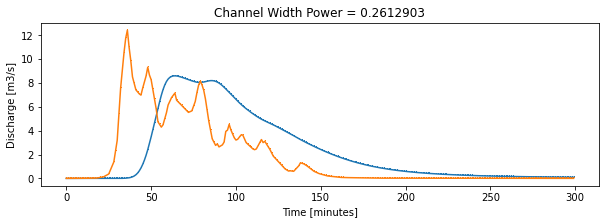

   param = 0.27741936
   cost  = 46.699126301401314
   run_time = 0.039068714777628584 [minutes]


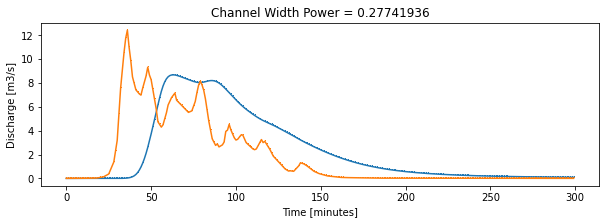

   param = 0.29354838
   cost  = 46.478053313866745
   run_time = 0.039377633730570474 [minutes]


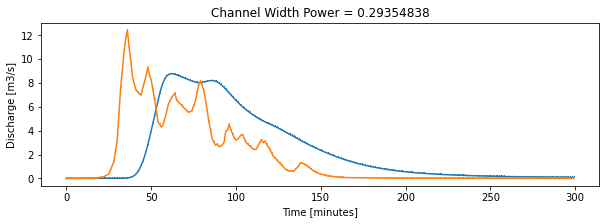

   param = 0.30967742
   cost  = 46.25969294604716
   run_time = 0.039195517698923744 [minutes]


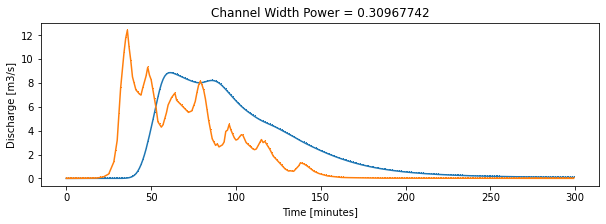

   param = 0.32580644
   cost  = 46.04335997428234
   run_time = 0.04432293176651001 [minutes]


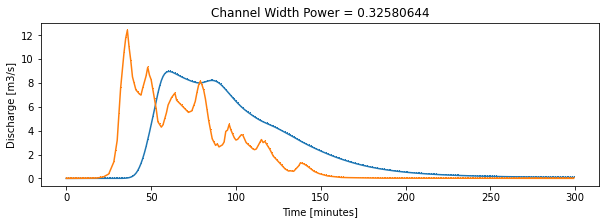

   param = 0.3419355
   cost  = 45.828390004285005
   run_time = 0.0437444011370341 [minutes]


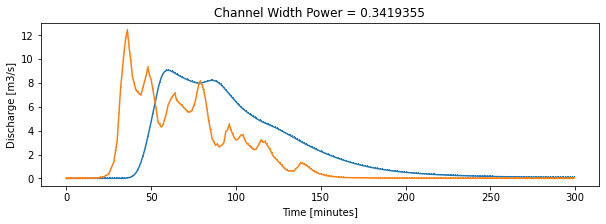

   param = 0.3580645
   cost  = 45.61416367168744
   run_time = 0.04144260088602702 [minutes]


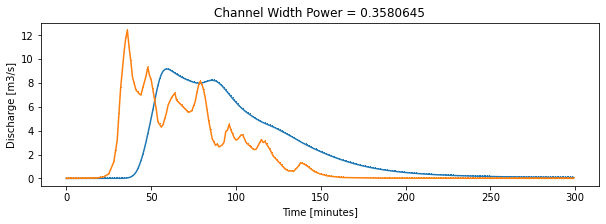

   param = 0.37419355
   cost  = 45.400124077520374
   run_time = 0.03943295081456502 [minutes]


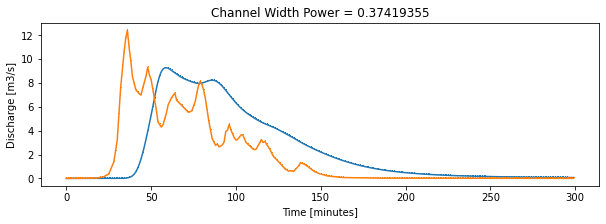

   param = 0.39032257
   cost  = 45.18579466300049
   run_time = 0.046531283855438234 [minutes]


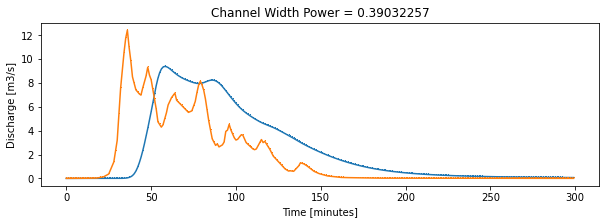

   param = 0.4064516
   cost  = 44.97078590673158
   run_time = 0.04335556825002034 [minutes]


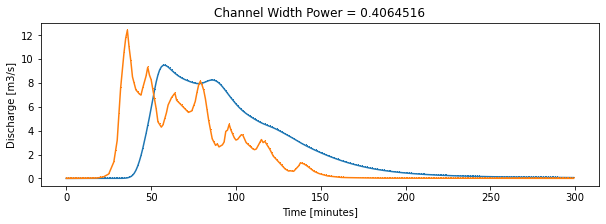

   param = 0.42258063
   cost  = 44.75480844059378
   run_time = 0.04052894512812297 [minutes]


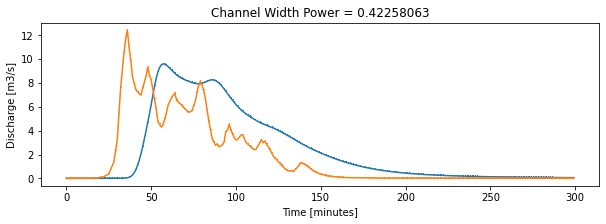

   param = 0.43870968
   cost  = 44.53767163888763
   run_time = 0.04304434855779012 [minutes]


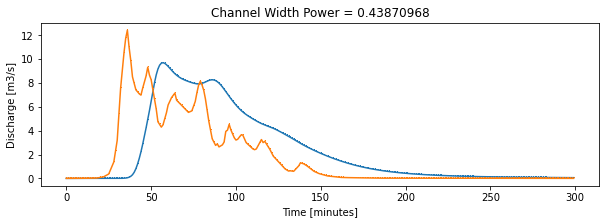

   param = 0.4548387
   cost  = 44.31928658394389
   run_time = 0.04083896478017171 [minutes]


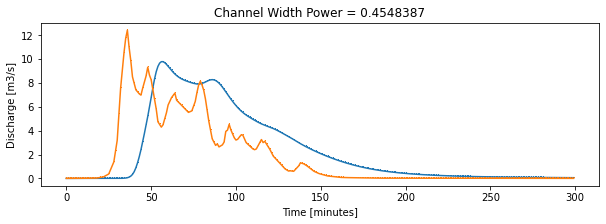

   param = 0.47096774
   cost  = 44.09966041478825
   run_time = 0.041820967197418214 [minutes]


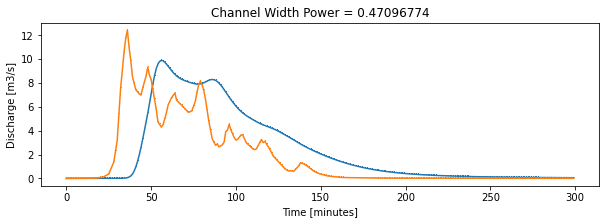

   param = 0.48709676
   cost  = 43.878895010061996
   run_time = 0.04340183734893799 [minutes]


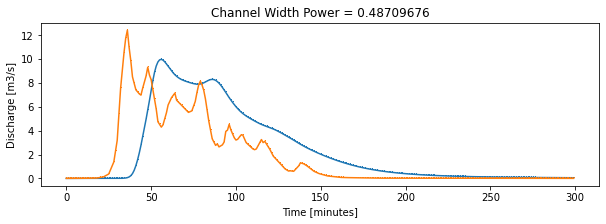

   param = 0.5032258
   cost  = 43.65717327720777
   run_time = 0.04493170181910197 [minutes]


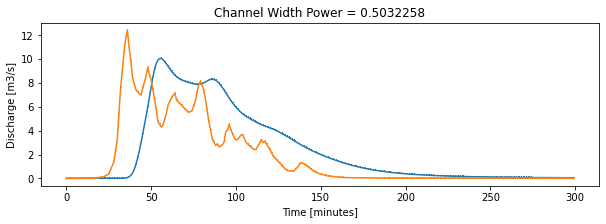

   param = 0.5193548
   cost  = 43.43475764210681
   run_time = 0.04499554634094238 [minutes]


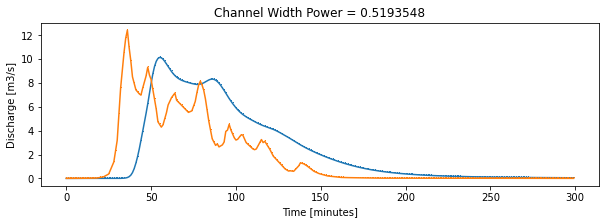

   param = 0.5354839
   cost  = 43.21197134675695
   run_time = 0.04212221701939901 [minutes]


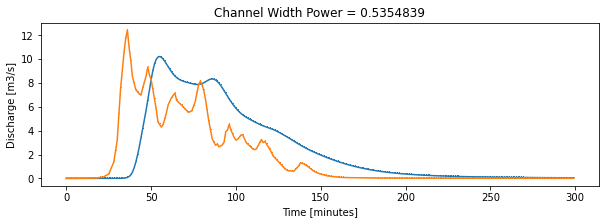

   param = 0.5516129
   cost  = 42.98920019280153
   run_time = 0.04327809810638428 [minutes]


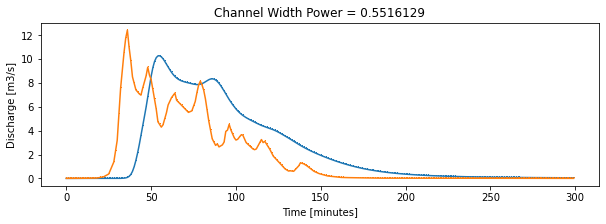

   param = 0.56774193
   cost  = 42.76686986848894
   run_time = 0.04074925184249878 [minutes]


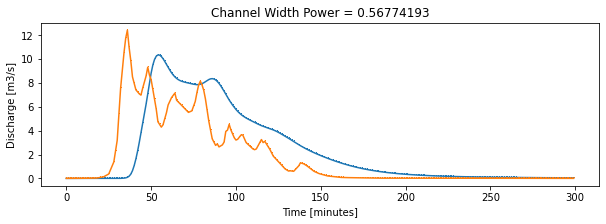

   param = 0.58387095
   cost  = 42.54544242796739
   run_time = 0.039554198582967125 [minutes]


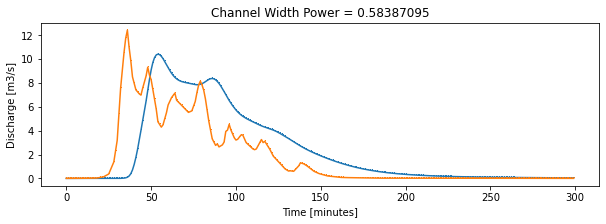

   param = 0.6
   cost  = 42.3254016621783
   run_time = 0.042037185033162436 [minutes]


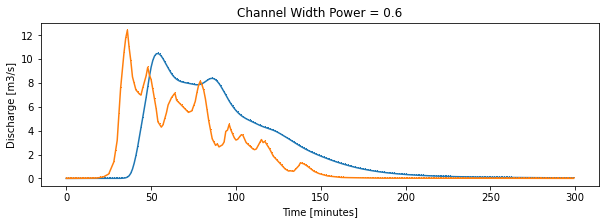

In [9]:
cal.calibrate( cal_var='channel_width_power', var_range=[0.1, 0.6], n_values=32, PLOT=True, SILENT=True )

### Calibration with Channel Width Max

Working...
   param = 1.0
   cost  = 29.896742839038453
   run_time = 0.04288796583811442 [minutes]


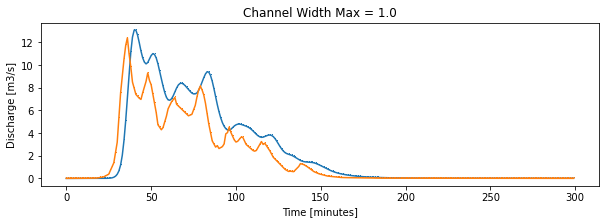

   param = 1.2903225
   cost  = 29.858283917115262
   run_time = 0.03927746613820394 [minutes]


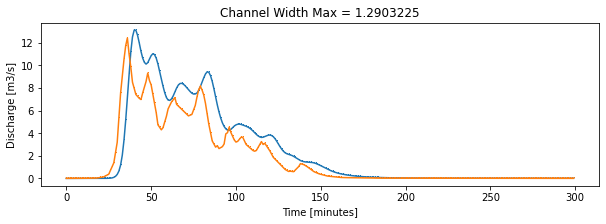

   param = 1.5806451
   cost  = 29.83476231732991
   run_time = 0.04197466770807902 [minutes]


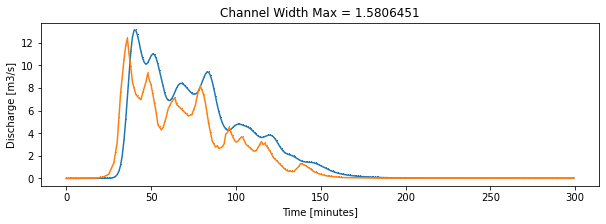

   param = 1.8709677
   cost  = 29.826057312744314
   run_time = 0.04206631978352864 [minutes]


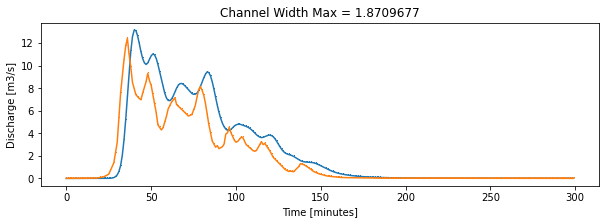

   param = 2.1612902
   cost  = 29.831546362106128
   run_time = 0.04176522095998128 [minutes]


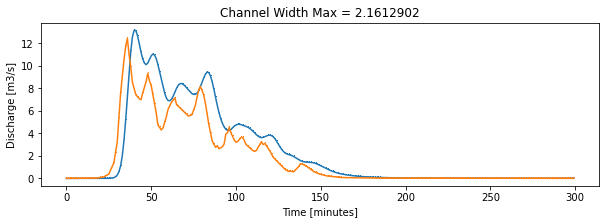

   param = 2.451613
   cost  = 29.850306862387203
   run_time = 0.04369623263676961 [minutes]


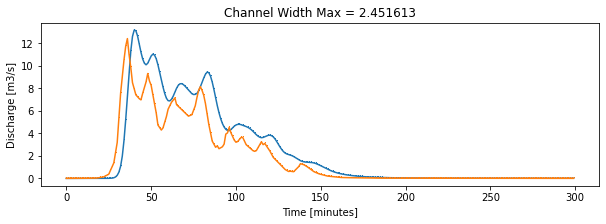

   param = 2.7419355
   cost  = 29.88126038309693
   run_time = 0.041738367080688475 [minutes]


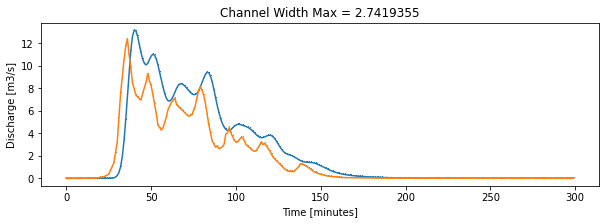

   param = 3.032258
   cost  = 29.92326409212866
   run_time = 0.03994919856389364 [minutes]


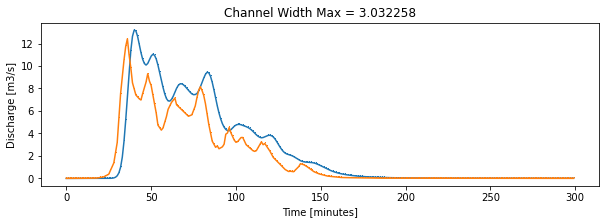

   param = 3.3225806
   cost  = 29.975173602347333
   run_time = 0.04197648763656616 [minutes]


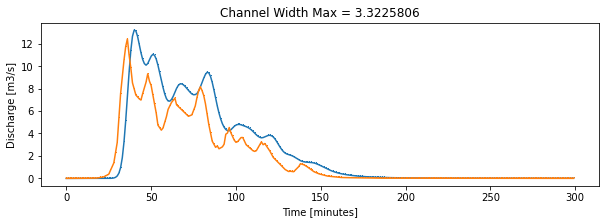

   param = 3.612903
   cost  = 30.035879278371187
   run_time = 0.04093174934387207 [minutes]


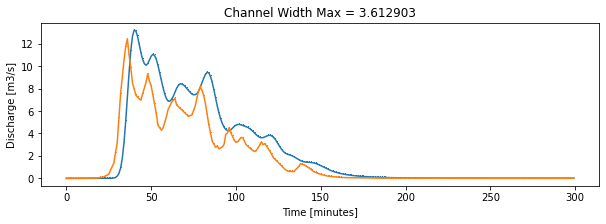

   param = 3.9032257
   cost  = 30.10433254225178
   run_time = 0.042295066515604655 [minutes]


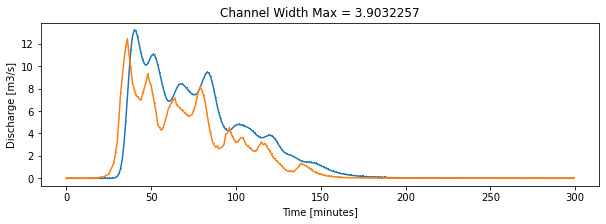

   param = 4.193548
   cost  = 30.179553391659745
   run_time = 0.04094370206197103 [minutes]


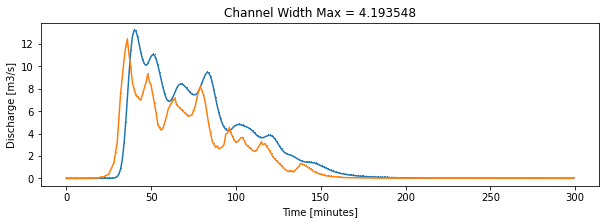

   param = 4.483871
   cost  = 30.26063941107349
   run_time = 0.041623214880625405 [minutes]


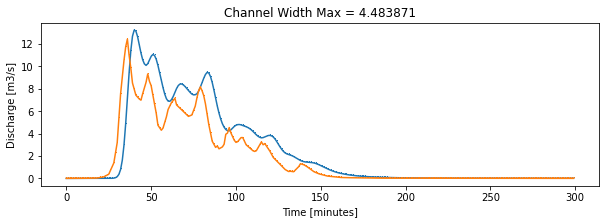

   param = 4.774194
   cost  = 30.34676503126366
   run_time = 0.039037648836771646 [minutes]


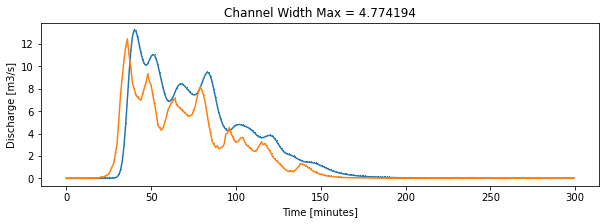

   param = 5.064516
   cost  = 30.437179864850318
   run_time = 0.03970046838124593 [minutes]


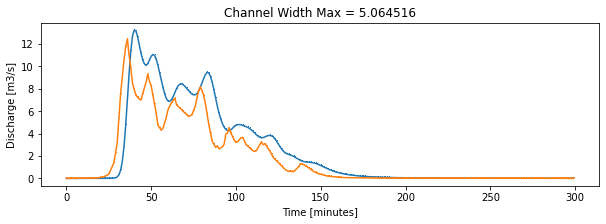

   param = 5.3548384
   cost  = 30.53120508971064
   run_time = 0.039816415309906004 [minutes]


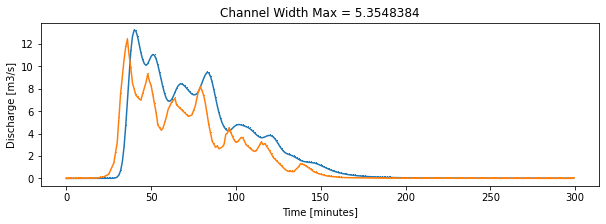

   param = 5.645161
   cost  = 30.628228252939472
   run_time = 0.041479150454203285 [minutes]


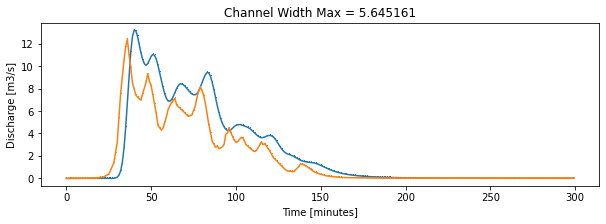

   param = 5.935484
   cost  = 30.727701202334732
   run_time = 0.04441351493199666 [minutes]


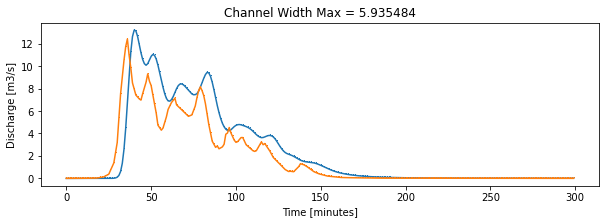

   param = 6.225806
   cost  = 30.8291308393844
   run_time = 0.03923537333806356 [minutes]


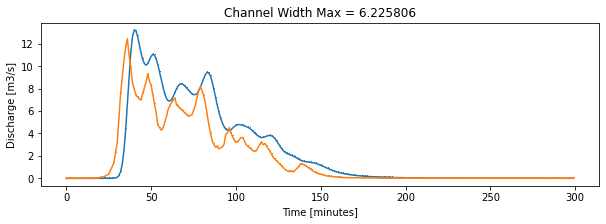

   param = 6.516129
   cost  = 30.932078798748517
   run_time = 0.04028894901275635 [minutes]


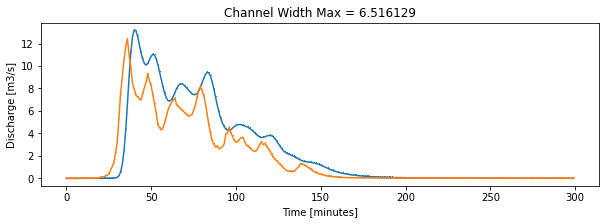

   param = 6.8064513
   cost  = 31.03615181268198
   run_time = 0.039436797300974526 [minutes]


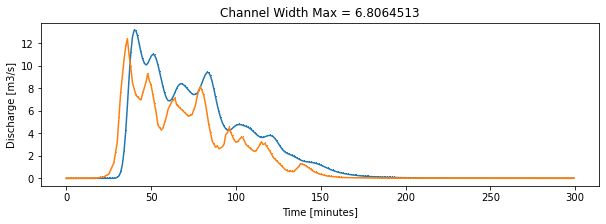

   param = 7.096774
   cost  = 31.14100140578647
   run_time = 0.039297048250834146 [minutes]


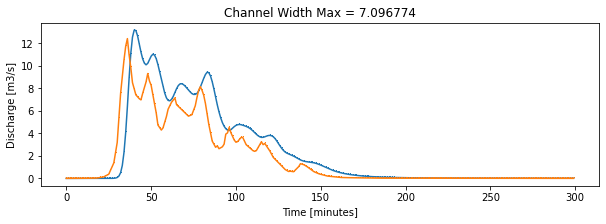

   param = 7.3870964
   cost  = 31.246319008281525
   run_time = 0.03930584987004598 [minutes]


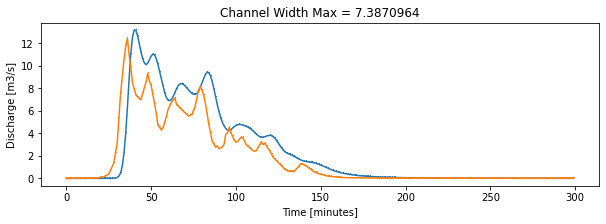

   param = 7.6774197
   cost  = 31.351829938490127
   run_time = 0.04295954704284668 [minutes]


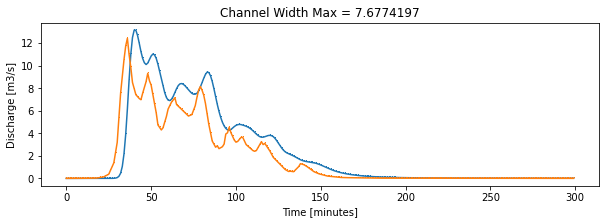

   param = 7.967742
   cost  = 31.45729319582762
   run_time = 0.04405176639556885 [minutes]


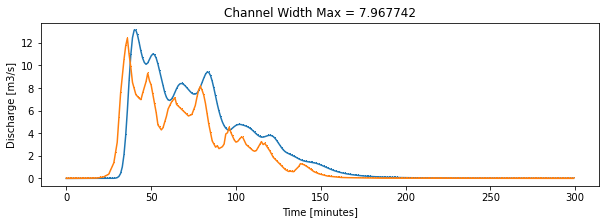

   param = 8.258064
   cost  = 31.562497043600892
   run_time = 0.04185776710510254 [minutes]


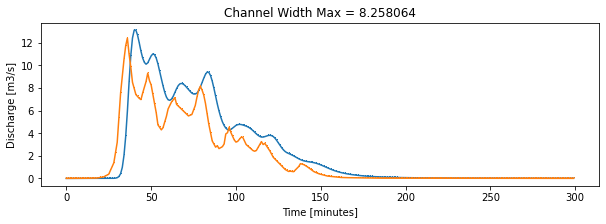

   param = 8.548388
   cost  = 31.66725596174835
   run_time = 0.04120829502741496 [minutes]


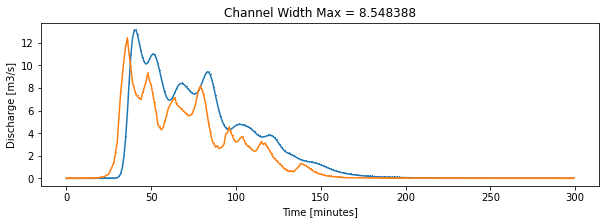

   param = 8.83871
   cost  = 31.771408143094753
   run_time = 0.040702350934346515 [minutes]


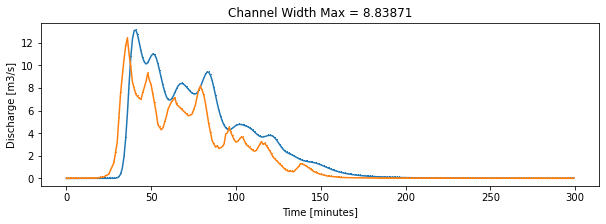

   param = 9.129032
   cost  = 31.87481238531312
   run_time = 0.039370803038279216 [minutes]


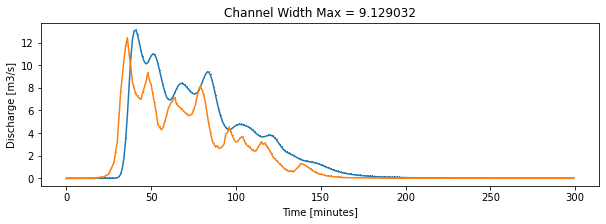

   param = 9.419354
   cost  = 31.977348375630992
   run_time = 0.04202966690063477 [minutes]


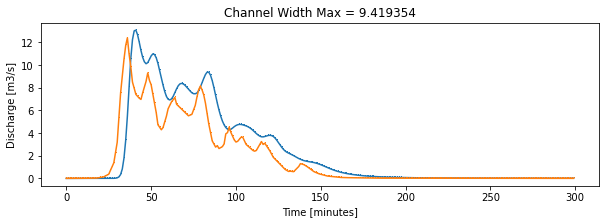

   param = 9.709677
   cost  = 32.07891237998141
   run_time = 0.04263338645299276 [minutes]


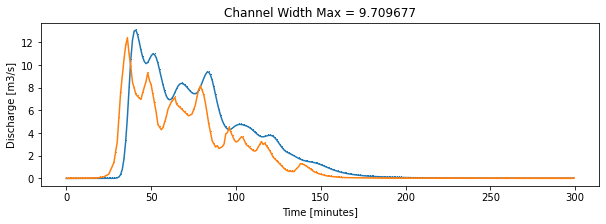

   param = 10.0
   cost  = 32.17941666608375
   run_time = 0.04284576574961344 [minutes]


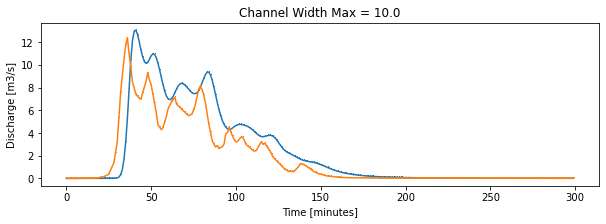

In [10]:
cal.calibrate( cal_var='channel_width_max', var_range=[1, 10], n_values=32, PLOT=True, SILENT=True )

## Conclusions   <a id="conclusions_G"></a>

The purpose of this notebook was to illustrate the basic concepts of how to calibrate the TopoFlow hydrologic model by varying only one parameter at a time and then showing the observed and predicted hydrographs as plots, along with the associated value of the cost function.  The TopoFlow utilities <b>calibrate.py</b>, <b>parameterize.py</b> and <b>visualize.py</b> in topoflow/utils do the work.

This notebook will be expand to vary multiple parameters soon, and to discuss the results in more detail.

## Other Jupyter Notebooks for TopoFlow 3.6  <a id="notebooks_G"></a>

There is a growing collection of Jupyter notebooks to demonstrate the functionality of the TopoFlow 3.6 hydrologic model and its numerous utilities.  These are all available at:
https://github.com/peckhams/topoflow36.

Peckham, S.D. (2019) A Jupyter notebook for getting started with TopoFlow 3.6.  https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Getting_Started.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to illustrate new data preparation utilities in TopoFlow 3.6.  https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Utils_Demo1.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to create visualizations of model output from TopoFlow 3.6. (version 2) https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Visualization_v2.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the use of global rainfall products such as GPM and GLDAS as inputs to TopoFlow.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Rainfall_Inputs.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the flood modeling (overbank flow) capabilities of TopoFlow 3.6.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Flood_Modeling.ipynb.

Peckham, S.D. (2020) A Jupyter notebook to check and explore the TopoFlow solar radiation utilities, which includes shortwave and longwave radiation calculators. (Only shows a few of the capabilities so far.)
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Radiation.ipynb.

## Key References for TopoFlow  <a id="refs_G"></a>

Peckham, S.D., M. Stoica, E.E. Jafarov, A. Endalamaw and W.R. Bolton (2017) Reproducible, component-based modeling with TopoFlow, a spatial hydrologic modeling toolkit, Earth and Space Science,4(6), 377-394, special issue: Geoscience Papers of the Future, American Geophysical Union, http://dx.doi.org/10.1002/2016EA000237.

Peckham, S.D. (2009) Geomorphometry and spatial hydrologic modeling, In: Hengl, T. and Reuter, H.I. (Eds), Geomorphometry: Concepts, Software and Applications, Chapter 25, Developments in Soil Science, vol. 33, Elsevier, 579-602, http://dx.doi.org/10.1016/S0166-2481(08)00025-1.  (TopoFlow)

Jiang, P., M. Elag, P. Kumar, S.D. Peckham, L. Marini, R. Liu (2017) A service-oriented architecture for coupling web service models using the Basic Model Interface (BMI), Environmental Modelling & Software, 92, 107-118, http://dx.doi.org/10.1016/j.envsoft.2017.01.021.

Zhang, Z., D.L. Kane and L.D. Hinzman (2000) Development and application of a spatially-distributed Arctic hydrological and thermal process model (ARHYTHM),
Hydrological Processes, 14(6), 1017-1044,
<a href="https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G">
    https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G</a>.

Peckham, S.D. (2014a) EMELI 1.0:  An experimental smart modeling framework for automatic coupling of self-describing models, Proceedings of HIC 2014, 11th International Conf. on Hydroinformatics, New York, NY. CUNY Academic Works, http://academicworks.cuny.edu/cc_conf_hic/464/.

Peckham, S.D. (2014b) The CSDMS Standard Names:  Cross-domain naming conventions for describing process models, data sets and their associated variables, Proceedings of the 7th Intl. Congress on Env. Modelling and Software, International Environmental Modelling and Software Society (iEMSs), San Diego, CA. (Eds.  D.P. Ames, N.W.T. Quinn, A.E. Rizzoli),  Paper 12. http://scholarsarchive.byu.edu/iemssconference/2014/Stream-A/12/.

Peckham, S.D., E.W.H. Hutton and B. Norris (2013) A component-based approach to integrated modeling in the geosciences: The Design of CSDMS, Computers & Geosciences, special issue: Modeling for Environmental Change, 53, 3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.

Peckham, S.D. (2018) Using the open-source TopoFlow Python package for extracting D8 grids from DEMs and for fluvial landscape evolution modeling, Proceedings of Geomorphometry 2018, Boulder, CO, pp. O-11-1 to O-11-4, http://2018.geomorphometry.org/Peckham_2018_geomorphometry.pdf


## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup_G"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments.  You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b> (2.2.3),
        <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3), <b>pip</b> (20.0.2),
        <b>setuptools</b> (46.4.0) and <b>traitlets</b> (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".  Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:tf36\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:tf36\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.

#### <b>JupyterLab Extensions</b>

The Jupyter project provides documentation on
[<b>JupyterLab Extensions</b>](https://jupyterlab.readthedocs.io/en/stable/user/extensions.html)
which add capabilities to JupyterLab.  For example, after installing jupyterlab (see just above), if you want to use the <b>ipywidgets</b> and <b>ipyleaflet</b> Python packages, you need to install two extensions, as follows:
```
% conda activate tf36
% jupyter labextension install jupyter-leaflet
% jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
To list the jupyter labextensions you have, and to see whether or not they are enabled, type <b>jupyter labextension list</b>.  <b>Note:</b> If you start jupyterlab from a conda environment in which a given extension is not installed, and then open or switch to a notebook which uses a different "environment kernel", one that requires that extension, the notebook may not work.

You should only install trusted extensions, due to security concerns, as explained in the documentation.  Third-party extensions pose a potential security risk.  An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization)
and can be installed with the command:
```
% jupyter labextension install @jupyterlab/mp4-extension
```
<b>Note:</b> This command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

As of May 27, 2020, JupyterLab has added an experimental <b>Extension Manager</b> which can be enabled by choosing Settings > Enable Extension Manager in the app.
